<h1>Digit Classification with Softmax</h1>


<h2>Objectives</h2>

<ul>
    <li>Download the Training and Validation MNIST Digit Images</li>
    <li>Create a Softmax Classifier using PyTorch</li>
    <li>Create a Criterion, Optimizer, and Data Loaders</li>
    <li>Create a Data Loader and set the Batch Size</li>
    <li>Train a Model</li>
    <li>Analyze Results and Model</li>
</ul> 


## Preparation

In [48]:
# install libraries
!pip3 install torch torchvision torchaudio

In [49]:
# Import libraries

# PyTorch Library
import torch 
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to get the digit dataset
import torchvision.datasets as dsets
# Creating graphs
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

In [50]:
# Helper function to plot the parameters

def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

In [51]:
# Plot the data

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1].item()))

## Load the Data

In [52]:
# Create data and load the training data set
train_dataset = dsets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [53]:
# Create data and load the validation data set
validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the validation dataset:\n ", validation_dataset)

Print the validation dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


### Accessing the data by indexing it

The label:  1


AttributeError: 'int' object has no attribute 'item'

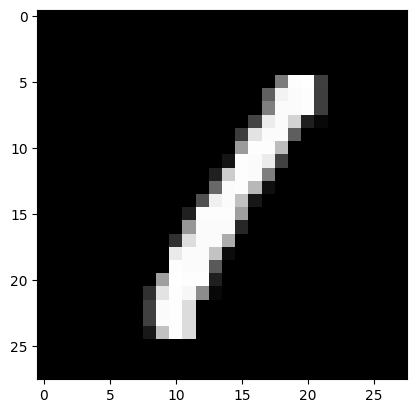

In [54]:

# Print the label

print("The label: ", train_dataset[3][1])
# Print the image and label
print("First Image and Label", show_data(train_dataset[3]))

In [ ]:
# Print the label

print("The label: ", train_dataset[0][1])
# Plot the image

print("The image: ", show_data(train_dataset[0]))

## Build a SoftMax Classifier

In [ ]:
# Define softmax classifier class
# Inherits nn.Module which is the base class for all neural networks
class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [ ]:
# check the shape of the training dataset
train_dataset[0][0].shape

In [ ]:
# set the dimentions
input_dim = 28 * 28
# there are 10 possible digits
output_dim = 10

In [ ]:
model = SoftMax(input_dim, output_dim)
print('Print the model:\n', model)

In [ ]:
# check the weight and bias parameters
print('W: ', list(model.parameters())[0].size())
print('B: ', list(model.parameters())[1].size())

In [ ]:
# plot the model parameter before training
PlotParameters(model)

 Before training the model, we have to flatten it

In [ ]:
# flattening the x values
X = train_dataset[0][0]
X = X.view(-1, 28*28)
print(X.shape)
# Now we can make a prediction, each class has a value, and the higher it is the more confident the model is that it is that digit
model(X)

In [ ]:
# Define the learning rate, optimizer, criterion, and data loader

learning_rate = 0.1
# the optimizer updates the model parameter as per the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# The criterion will measure the loss between the prediction and actual label values
# This is where the SoftMax occurs, it is built into the Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Created a training data loader so we can set the batch size
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100)
# Created a validation data loader so we can set the batch size
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=5000)

In [ ]:
model_output = model(X)
actual = torch.tensor([train_dataset[0][1]])

print("Output: ", model_output)
print("Actual:", actual)

In [ ]:
criterion(model_output, actual)

cross entropy loss takes in probabilities, so we have to change the mode_output to a probability

In [ ]:
# softmax changes the mode_output to a probability
softmax = nn.Softmax(dim = 1)
probability = softmax(model_output)
print(probability)

Now that we have probabilities, we can just calculate the negative log of the probability of the class that this image belongs to. The image belongs to the target class so we calculate the negative log of the probability at the target index.

In [ ]:
-1*torch.log(probability[0][actual])

### Train the model

In [ ]:
# Number of times we train our model useing the training data
n_epochs = 10
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
# Size of the validation data
N_test = len(validation_dataset)

# Function to train the model based on number of epochs
def train_model(n_epochs):
    # Loops n_epochs times
    for epoch in range(n_epochs):
        # For each batch in the train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
        
        # Each epoch we check how the model performs with data it has not seen which is the validation data, we are not training here
        correct = 0
        # For each batch in the validation loader
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model(x_test.view(-1, 28 * 28))
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()
        # Calculates the accuracy by dividing correct by size of validation dataset
        accuracy = correct / N_test
        # Keeps track loss
        loss_list.append(loss.data)
        # Keeps track of the accuracy
        accuracy_list.append(accuracy)

# Function call
train_model(n_epochs)

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [ ]:
# Plot the parameters

PlotParameters(model)

In [ ]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break       

In [ ]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break  